In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.compat.v1 as tf
import math
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

In [2]:
#Loading Energy consumption Dataset
#file = files.upload()
df = pd.read_csv("energydata_complete.csv",sep=',')
#printing the head of the Dataset
df=df.drop(['date'], axis=1) #Dropping Date Column in the Dataset
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [0]:
#Converting Energy consumption into a Binary Classification Problem
df['Appliances']=(df['Appliances']>int(df['Appliances'].mean())).astype(int)
#Splitting x and y
y=df['Appliances'].values
X=df.drop(['Appliances'], axis=1).values
#X=df[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',]].values
#Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=100)

In [0]:
def featureNormalize(X):
    X_norm = X
    mu    = np.zeros((1, X.shape[1]))
    sigma = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
      mu[:,i] = np.mean(X[:,i])
      sigma[:,i] = np.std(X[:,i])
      X_norm[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm, mu, sigma

In [0]:
X_norm, mu, sigma = featureNormalize(X_train)
X_train = X_norm
X_test = (X_test - mu)/sigma

In [6]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(13814, 27) (13814,)
(5921, 27) (5921,)


In [0]:
X_train_flatten  = X_train.reshape(X_train.shape[0],-1).T
y_train_flatten = y_train.reshape(y_train.shape[0],-1).T
X_test_flatten  = X_test.reshape(X_test.shape[0],-1).T
y_test_flatten = y_test.reshape(y_test.shape[0],-1).T

In [0]:
X_train = X_train_flatten
X_test = X_test_flatten
y_train = y_train_flatten
y_test = y_test_flatten

In [9]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(27, 13814) (1, 13814)
(27, 5921) (1, 5921)


In [0]:
@tf.function
def create_placeholders(n_x, n_y):
  X = tf.placeholder(tf.float32,[n_x,None]) # Since we have 27 features as input
  y = tf.placeholder(tf.float32,[n_y,None])  # Since we have 1 outut labels
  return X,y

In [0]:
def initialize_parameters(layer_dims):
  tf.set_random_seed(1)  
  parameters = {}
  L = len(layer_dims)       

  for l in range(1, L):
    #Intializing Parameters
    parameters['W' + str(l)] = tf.get_variable('W' + str(l) ,shape = [layer_dims[l],layer_dims[l-1]],initializer = tf.initializers.glorot_normal())
    parameters['b' + str(l)] = tf.get_variable('b' + str(l) ,shape = [layer_dims[l],1],initializer = tf.zeros_initializer)
 
  return parameters

In [0]:
@tf.function
def relu(Z):  
    A = tf.nn.relu(Z)
    cache = Z 
    return A, cache

In [0]:
@tf.function
def sigmoid(Z):
    A = tf.nn.sigmoid(Z)
    cache = Z
    
    return A, cache

In [0]:
def linear_forward(A, W, b):
    
    Z = tf.matmul(W,A) + b

    cache = (A, W, b)
    
    return Z, cache

In [0]:
@tf.function
def linear_activation_forward(A_prev, W, b, activation):

  if activation == "sigmoid":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = sigmoid(Z)

  elif activation == "relu":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache)

  return A, cache

In [0]:
@tf.function
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    #assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [0]:
@tf.function
def compute_cost(AL, Y):
    logits = tf.transpose(AL)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.math.squared_difference(logits,labels))
    return cost

In [0]:
### CONSTANTS ###
layers_dims = [27, 20, 10, 5, 1] #  4-layer model

In [19]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(27,1)
    parameters = initialize_parameters(layers_dims)
    AL, caches = L_model_forward(X, parameters)
    cost = compute_cost(AL, Y)
    print("cost = " + str(cost))
    print(parameters)

cost = Tensor("PartitionedCall_2:0", shape=(), dtype=float32)
{'W1': <tf.Variable 'W1:0' shape=(20, 27) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(20, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(10, 20) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(10, 1) dtype=float32_ref>, 'W3': <tf.Variable 'W3:0' shape=(5, 10) dtype=float32_ref>, 'b3': <tf.Variable 'b3:0' shape=(5, 1) dtype=float32_ref>, 'W4': <tf.Variable 'W4:0' shape=(1, 5) dtype=float32_ref>, 'b4': <tf.Variable 'b4:0' shape=(1, 1) dtype=float32_ref>}


In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
   
    m = X.shape[1]                 # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.01,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 30                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    
    # Forward propagation
    AL, caches = L_model_forward(X, parameters)
    
    # Cost function
    cost = compute_cost(AL, Y)
    
    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
          
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        # plt.plot(np.squeeze(costs))
        # plt.ylabel('cost')
        # plt.xlabel('iterations (per tens)')
        # plt.title("Learning rate =" + str(learning_rate))
        # plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        predicted = AL

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.round(predicted), Y)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        Training_Accuracy = accuracy.eval({X: X_train, Y: Y_train})
        Testing_Accuracy  = accuracy.eval({X: X_test, Y: Y_test})
        print ("Train Accuracy:", Training_Accuracy)
        print ("Test Accuracy:", Testing_Accuracy)
        
        return parameters, costs, Training_Accuracy, Testing_Accuracy

In [22]:
### CONSTANTS ###
layers_dims = [27, 20, 10, 5, 1] #  3-layer hidden model
batches = [100,250,500,2000,5000,10000]
cost_dict=dict()
train_acc = []
test_acc = []
for batch in batches:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = 500,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dims)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.913204
Test Accuracy: 0.8733322
Parameters have been trained!
Train Accuracy: 0.92399013
Test Accuracy: 0.8789056
Parameters have been trained!
Train Accuracy: 0.92167366
Test Accuracy: 0.87434554
Parameters have been trained!
Train Accuracy: 0.9170407
Test Accuracy: 0.87062997
Parameters have been trained!
Train Accuracy: 0.9139279
Test Accuracy: 0.87823004
Parameters have been trained!
Train Accuracy: 0.90922254
Test Accuracy: 0.8702922


In [23]:
df1 = pd.DataFrame(
    {'MiniBatch Size': batches,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df2 = pd.DataFrame(
    {'MiniBatch Size': batches,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_mini = pd.concat([df1, df2],sort=False)
df_mini['Accuracy'] = (df_mini['Accuracy'] * 100).round(2)
df_mini

,MiniBatch Size,Acc,Accuracy
0,100,TrainingAccuracy,91.32
1,250,TrainingAccuracy,92.40
2,500,TrainingAccuracy,92.17
3,2000,TrainingAccuracy,91.70
4,5000,TrainingAccuracy,91.39
5,10000,TrainingAccuracy,90.92
0,100,TestingAccuracy,87.33
1,250,TestingAccuracy,87.89
2,500,TestingAccuracy,87.43
3,2000,TestingAccuracy,87.06


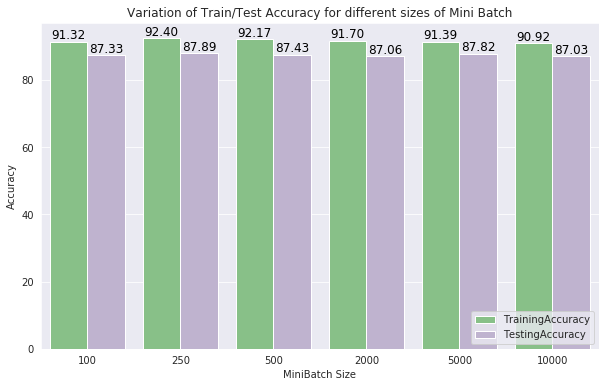

In [24]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="MiniBatch Size", y="Accuracy", hue="Acc",palette="Accent", data=df_mini)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different sizes of Mini Batch')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_mini.png",dpi=150)

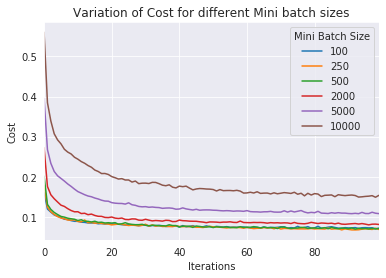

In [25]:
cost_df = pd.DataFrame(cost_dict)
cost_df.plot()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Variation of Cost for different Mini batch sizes")
plt.legend(title='Mini Batch Size')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.savefig("output_line.png",dpi=150)
plt.show()

In [26]:
### CONSTANTS ###
#Different Layer Broadness
layers_dims = [[27, 20, 10, 5, 1],
               [27,200,100,50,1],
               [27,500,250,100,1],
               [27,1000,500,250,1]]#  4-layer hidden model
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
for layers_dim in layers_dims:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = 500,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dim)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.9114666
Test Accuracy: 0.87282556
Parameters have been trained!
Train Accuracy: 0.9761112
Test Accuracy: 0.87519
Parameters have been trained!
Train Accuracy: 0.73555815
Test Accuracy: 0.7368688
Parameters have been trained!
Train Accuracy: 0.73555815
Test Accuracy: 0.7368688


In [0]:
df11 = pd.DataFrame(
    {'Accuracy': 'TrainingAccuracy',
     'Accuracy_val': train_acc
    })
df11["Layer number"] = df11.index + 1
df11[['i/p','HL1','HL2','HL3','o/p']] = pd.DataFrame(layers_dims)

df21 = pd.DataFrame(
    {'Accuracy': 'TestingAccuracy',
     'Accuracy_val': test_acc
    })
df21["Layer number"] = df21.index + 1
df21[['i/p','HL1','HL2','HL3','o/p']] = pd.DataFrame(layers_dims)

df_broad = pd.concat([df11, df21],sort=False)
df_broad['Accuracy_val'] = (df_broad['Accuracy_val'] * 100).round(2)

df_broad = df_broad[['Layer number', 'i/p', 'HL1', 'HL2', 'HL3','o/p','Accuracy', 'Accuracy_val']]

In [41]:
df_broad

,Layer number,i/p,HL1,HL2,HL3,o/p,Accuracy,Accuracy_val
0,1,27,20,10,5,1,TrainingAccuracy,91.15
1,2,27,200,100,50,1,TrainingAccuracy,97.61
2,3,27,500,250,100,1,TrainingAccuracy,73.56
3,4,27,1000,500,250,1,TrainingAccuracy,73.56
0,1,27,20,10,5,1,TestingAccuracy,87.28
1,2,27,200,100,50,1,TestingAccuracy,87.52
2,3,27,500,250,100,1,TestingAccuracy,73.69
3,4,27,1000,500,250,1,TestingAccuracy,73.69


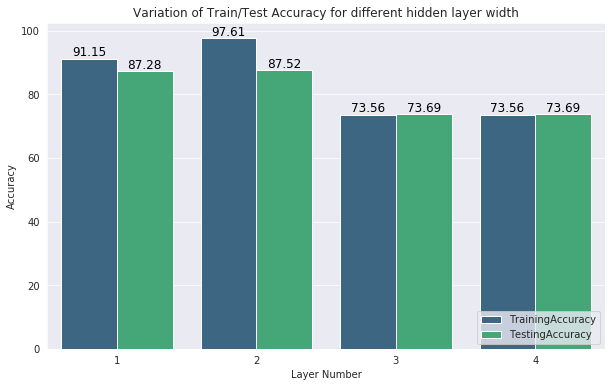

In [52]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Layer number", y="Accuracy_val", hue="Accuracy",palette='viridis', data=df_broad)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different hidden layer width')
ax.set(xlabel='Layer Number', ylabel='Accuracy')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_broad.png",dpi=150)

In [49]:
### CONSTANTS ###
#Varying Number of Epochs
layers_dims = [27, 20, 10, 5, 1]#  4-layer hidden model
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
num_epochs = [50,100,250,500,750,1000,2000,3000]
for num_epoch in num_epochs:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = num_epoch,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dims)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.8778051
Test Accuracy: 0.8549231
Parameters have been trained!
Train Accuracy: 0.8960475
Test Accuracy: 0.8711366
Parameters have been trained!
Train Accuracy: 0.910236
Test Accuracy: 0.8714744
Parameters have been trained!
Train Accuracy: 0.9114666
Test Accuracy: 0.87282556
Parameters have been trained!
Train Accuracy: 0.9200811
Test Accuracy: 0.8746833
Parameters have been trained!
Train Accuracy: 0.9242073
Test Accuracy: 0.87062997
Parameters have been trained!
Train Accuracy: 0.9251484
Test Accuracy: 0.87062997
Parameters have been trained!
Train Accuracy: 0.9309396
Test Accuracy: 0.87400776


In [0]:
df31 = pd.DataFrame(
    {'No. of Epochs': num_epochs,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df32 = pd.DataFrame(
    {'No. of Epochs': num_epochs,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_epoch = pd.concat([df31, df32],sort=False)
df_epoch['Accuracy'] = (df_epoch['Accuracy'] * 100).round(2)

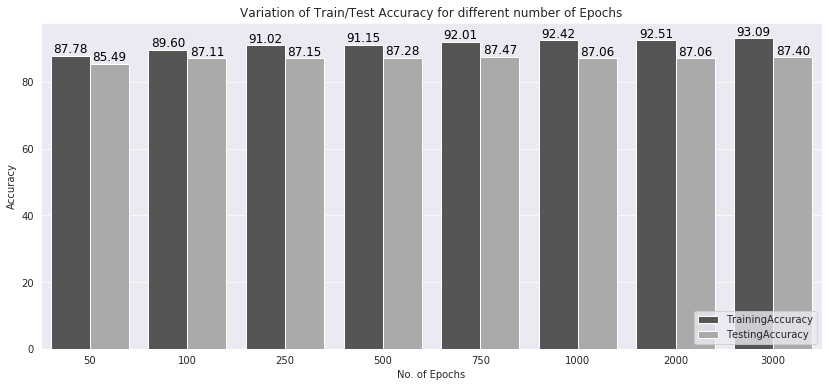

In [63]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(14,6))
ax = sns.barplot(x="No. of Epochs", y="Accuracy", hue="Acc",palette="gist_gray", data=df_epoch)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different number of Epochs')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_epoch.png",dpi=150)

In [65]:
### CONSTANTS ###
layers_dims = [[27,20, 10, 5, 1],
               [27,30,20,10,5,1],
               [27,30,25,20,10,5,1],
               [27,35,30,25,20,10,5,1],
               [27,40,35,30,25,20,10,5,1]]
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
for layers_dim in layers_dims:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = 0.01,num_epochs = 500,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dim)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.9114666
Test Accuracy: 0.87282556
Parameters have been trained!
Train Accuracy: 0.9499783
Test Accuracy: 0.86877215
Parameters have been trained!
Train Accuracy: 0.94585204
Test Accuracy: 0.87772334
Parameters have been trained!
Train Accuracy: 0.9567106
Test Accuracy: 0.87282556
Parameters have been trained!
Train Accuracy: 0.9664833
Test Accuracy: 0.87907445


In [0]:
no_of_hidden_layers=[3,4,5,6,7]
df41 = pd.DataFrame(
    {'no_of_hidden_layers' : no_of_hidden_layers,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df42 = pd.DataFrame(
    {'no_of_hidden_layers' : no_of_hidden_layers,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_hidden = pd.concat([df41, df42],sort=False)
df_hidden['Accuracy'] = (df_hidden['Accuracy'] * 100).round(2)

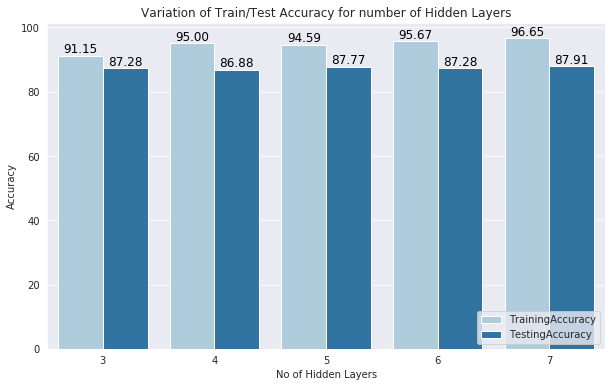

In [69]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="no_of_hidden_layers", y="Accuracy", hue="Acc",palette="Paired", data=df_hidden)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for number of Hidden Layers')
ax.set(xlabel='No of Hidden Layers', ylabel='Accuracy')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.savefig("output_hidden.png",dpi=150)

In [73]:
#Varying Learning Rates
layers_dims = [27, 20, 10, 5, 1]#  4-layer hidden model
batch = 1000 #mini batch size
cost_dict=dict()
train_acc = []
test_acc = []
num_epochs = 500
learning_rates = [0.5,0.1,0.05,0.01,0.005,0.001]
for learning_rate in learning_rates:
  _,costs,Training_Accuracy,Testing_Accuracy = parameters = model(X_train, y_train, X_test, y_test,learning_rate = learning_rate,num_epochs = num_epoch,
                                                                  minibatch_size = batch,print_cost = False,layers_dims=layers_dims)
  cost_dict[batch] = costs
  train_acc.append(Training_Accuracy)
  test_acc.append(Testing_Accuracy)

Parameters have been trained!
Train Accuracy: 0.73555815
Test Accuracy: 0.7368688
Parameters have been trained!
Train Accuracy: 0.75177354
Test Accuracy: 0.7446377
Parameters have been trained!
Train Accuracy: 0.9188504
Test Accuracy: 0.87519
Parameters have been trained!
Train Accuracy: 0.9309396
Test Accuracy: 0.87400776
Parameters have been trained!
Train Accuracy: 0.9370928
Test Accuracy: 0.87620336
Parameters have been trained!
Train Accuracy: 0.92840594
Test Accuracy: 0.8772167


In [0]:
df51 = pd.DataFrame(
    {'Learning Rate' : learning_rates,
     'Acc': 'TrainingAccuracy',
     'Accuracy': train_acc
    })
df52 = pd.DataFrame(
    {'Learning Rate' : learning_rates,
     'Acc': 'TestingAccuracy',
     'Accuracy': test_acc
    })

df_learning_rate = pd.concat([df51, df52],sort=False).reset_index(drop=True)
df_learning_rate['Accuracy'] = (df_learning_rate['Accuracy'] * 100).round(2)

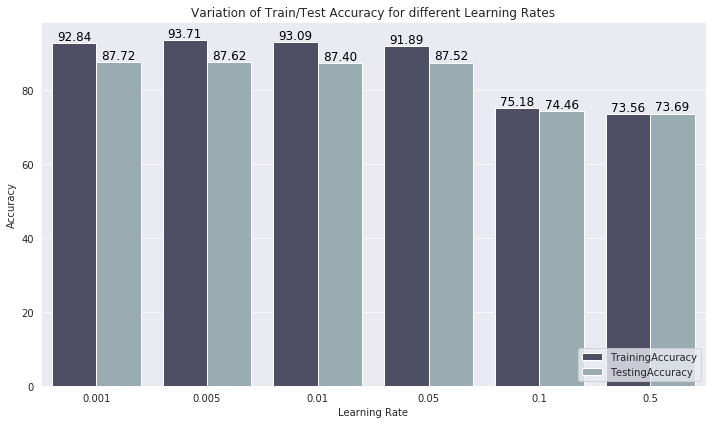

In [84]:
sns.set_style("darkgrid",
              {
                  'axes.grid' : True
              })
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Learning Rate", y="Accuracy", hue="Acc",palette="bone", data=df_learning_rate)
plt.legend(loc='lower right')
ax.set_title('Variation of Train/Test Accuracy for different Learning Rates')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color='black', ha='center', va='bottom')
plt.tight_layout()
plt.savefig("output_learning_rate.png",dpi=150)